In [315]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [316]:
emgfile_path = './data/nobed-3.txt'
emg_data = []
with open(emgfile_path, 'r') as f:
    for line in f.readlines()[10:]:
        cur = line.strip().split(',')[:-1]
        cur = [float(x.strip()) for x in cur]
        emg_data.append(cur)
emg_data = np.array(emg_data)
emg_data

array([[1.4000e+01, 3.2900e+02, 3.3000e+02, 3.2900e+02, 3.2900e+02],
       [1.6000e+01, 3.2900e+02, 3.3000e+02, 3.2800e+02, 3.3000e+02],
       [1.9000e+01, 3.2900e+02, 3.2900e+02, 3.2800e+02, 3.2800e+02],
       ...,
       [2.3305e+04, 3.1900e+02, 3.3000e+02, 3.3000e+02, 3.2900e+02],
       [2.3307e+04, 3.2000e+02, 3.3000e+02, 3.3100e+02, 3.2900e+02],
       [2.3310e+04, 3.2000e+02, 3.2900e+02, 3.3000e+02, 3.2800e+02]])

In [317]:
timestamp = emg_data[:, 0]
emg_data = emg_data[:, 1:]

In [318]:
emg_data = emg_data - np.mean(emg_data, axis=0)
emg_data

array([[ -0.32081556,   0.97836263,  -0.81441798,  -0.61260793],
       [ -0.32081556,   0.97836263,  -1.81441798,   0.38739207],
       [ -0.32081556,  -0.02163737,  -1.81441798,  -1.61260793],
       ...,
       [-10.32081556,   0.97836263,   0.18558202,  -0.61260793],
       [ -9.32081556,   0.97836263,   1.18558202,  -0.61260793],
       [ -9.32081556,  -0.02163737,   0.18558202,  -1.61260793]])

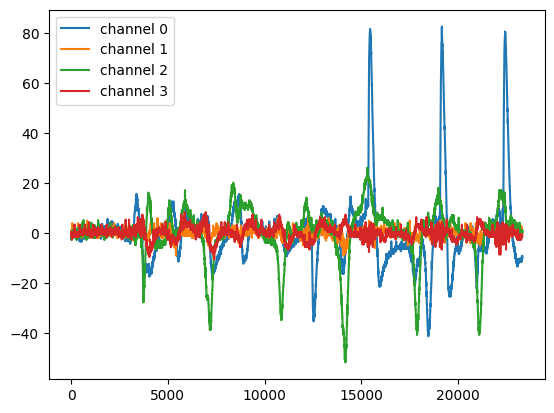

In [319]:
def plot_emg(emg_data):
    for i in range(4):
        plt.plot(timestamp,emg_data[:, i], label=f'channel {i}')
    plt.legend()
    plt.show()
plot_emg(emg_data)

In [320]:
bandpass_freq_low = 20
bandpass_freq_high = 150
lowpass_freq = 1
butterworth_order = 4
sampling_rate = len(emg_data) / (timestamp[-1] - timestamp[0]) * 1000
sampling_rate

412.64594780219784

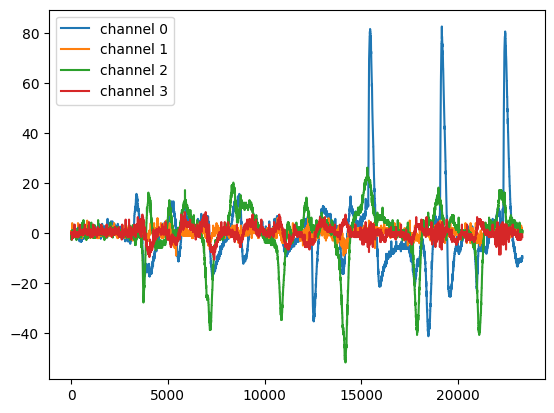

In [321]:
from scipy.signal import butter, sosfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos


def butter_bandpass_filter(data, lowcut, highcut, sample_rate, order=5):
    sos = butter_bandpass(lowcut, highcut, sample_rate, order=order)
    y = sosfilt(sos, data)
    return y

low = (2*bandpass_freq_low)/sampling_rate
high = (2*bandpass_freq_high)/sampling_rate
for i in range(4):
    emg_data[i, :] = butter_bandpass_filter(emg_data[i,:], low, high, sampling_rate, butterworth_order)

plot_emg(emg_data)


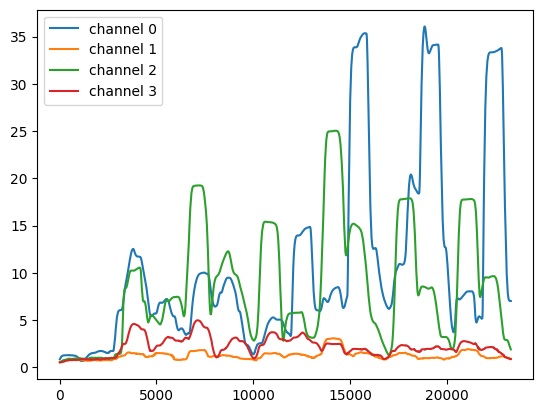

In [322]:
window_length = 400
window = np.ones(window_length) / window_length
# Line 19: Compute the RMS envelope using convolution
EMG = []
for i in range(4):
    squared_emg = emg_data[:,i] ** 2
    val = np.sqrt(np.convolve(squared_emg, window, mode='same'))
    EMG.append(val)
EMG = np.array(EMG).T
plot_emg(EMG)

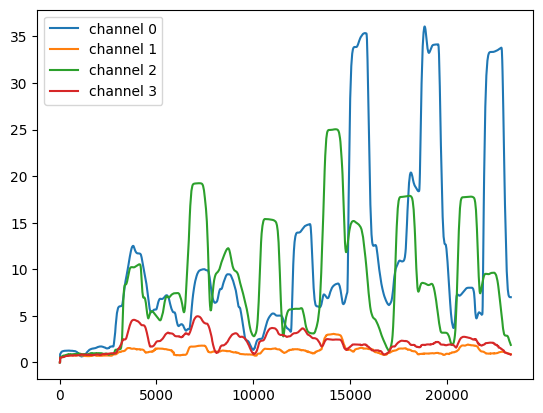

In [323]:
def butter_lowpass_sos(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyquist
    sos = butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    return sos

def sos_lowpass_filter(data, cutoff, fs, order=5):
    sos = butter_lowpass_sos(cutoff, fs, order=order)
    y = sosfilt(sos, data)
    return y
for i in range(4):
    EMG[i, :] = sos_lowpass_filter(EMG[i, :], lowpass_freq, sampling_rate, butterworth_order)
plot_emg(EMG)

In [324]:
np.mean(EMG, axis=0)

array([10.58553494,  1.24959037,  8.65280775,  2.21878683])

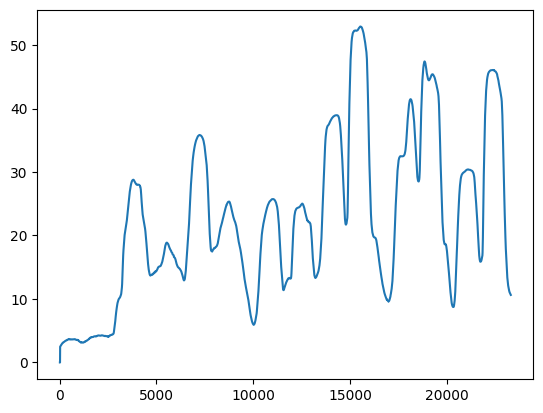

In [325]:
result = np.sum(EMG, axis=1)
plt.plot(timestamp, result)